In [488]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import random
import pickle
import networkx as nx
import os
from PIL import Image
import cv2
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [489]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# NUMBER_NODES = 10
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
# DATASET_PATH = f'./opt_band_{NUMBER_NODES}_nodes_graph.csv'
DATASET_PATH = f'../../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

In [490]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image / 255
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [491]:
training_data = CustomImageDataset(annotations_file='./annotations_file_train.csv', img_dir='./dataset_7')
val_data = CustomImageDataset(annotations_file='./annotations_file_val.csv', img_dir='./dataset_val_7')

In [492]:
BATCH_SIZE = 4
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [493]:
def getArray(strArray):
    arr = strArray.split('.')
    first = strArray[1]
    arr = [first, *arr[1 : -1]] # skip '[' and ']'
    arr = list(map(lambda x: int(x.strip()), arr))
    return np.array(arr)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 32, 32])
tensor([0, 2, 2, 1])
tensor(0)


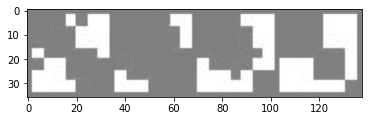

tensor(0) tensor(2) tensor(2) tensor(1)


In [494]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

print(type(images))
print(type(images[0]))
print(type(images[0][0]))
print(images[0].shape)
print(labels)
print(labels[0])

# # show images
imshow(torchvision.utils.make_grid(images))
# # print labels
print(' '.join('%5s' % labels[j] for j in range(BATCH_SIZE)))

In [495]:
class CustomLoss(torch.nn.Module):
    
    def __init__(self):
        super(CustomLoss,self).__init__()
    
    def loss_repeated_labels(self, output):
      used_labels, counts = torch.unique(output, return_counts=True)
      counts = counts.type(torch.DoubleTensor)
      diffLabelCounts = (output.shape[0] - counts.shape[0])**2
      sampleVariance = torch.var(counts, unbiased=False)

      if diffLabelCounts == 0 and sampleVariance != 0:
          diffLabelCounts = 1
      if sampleVariance == 0 and diffLabelCounts != 0:
          sampleVariance = 1
      return sampleVariance * diffLabelCounts

    def forward(self, output, target):
      loss_mse = ((output - target[1:])**2).mean()
      roundedOutput = output.round()
      loss_repeated = self.loss_repeated_labels(roundedOutput)
      if loss_mse == 0 and loss_repeated != 0:
        loss_mse = 1
      if loss_repeated == 0 and loss_mse != 0:
        loss_repeated = 1
      return loss_mse * loss_repeated

teste = CustomLoss()
y_pred = torch.tensor([1., 1., 1., 1., 1., 1., 1.])
#y_pred = torch.tensor([0., 1., 1., 2., 2., 3., 1.])
#y_pred = torch.tensor([0., 1., 2., 3., 4., 5., 6.])
y_true = torch.tensor([0., 0., 1., 2., 3., 4., 5., 6.])
teste.forward(y_pred, y_true)

tensor(288.)

In [511]:
def train(dataloader, model, optimizer, epoch):
    # criterion = CustomLoss()
    criterion = nn.MSELoss()
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        for input, target in zip(X, y):
            pred = model(X)
            one = torch.nn.functional.one_hot(target, num_classes=3)
            one = one.type(torch.float32)
            print(pred)
            print(one)
            loss = criterion(pred, one)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

    return (train_loss / len(dataloader))

In [512]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(50, 30, kernel_size=5)
        self.fc1 = nn.Linear(3000, 120)
        # 1x1600 and 13456x120
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [513]:
epochs = 10000

model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

list_train_loss = []
list_val_loss = []

for epoch in range(epochs):
    train_loss = train(train_dataloader, model, optimizer, epoch)
    list_train_loss.append(train_loss)

tensor([ 0.0117, -0.0959, -0.0619], grad_fn=<AddBackward0>)
tensor([0., 1., 0.])
tensor([ 0.0117, -0.0956, -0.0619], grad_fn=<AddBackward0>)
tensor([0., 1., 0.])
tensor([ 0.0116, -0.0952, -0.0619], grad_fn=<AddBackward0>)
tensor([1., 0., 0.])
tensor([ 0.0118, -0.0949, -0.0619], grad_fn=<AddBackward0>)
tensor([1., 0., 0.])
tensor([ 0.0112, -0.0991, -0.0597], grad_fn=<AddBackward0>)
tensor([0., 0., 1.])
tensor([ 0.0114, -0.0989, -0.0595], grad_fn=<AddBackward0>)
tensor([1., 0., 0.])
tensor([ 0.0118, -0.0987, -0.0593], grad_fn=<AddBackward0>)
tensor([0., 0., 1.])
tensor([ 0.0121, -0.0985, -0.0589], grad_fn=<AddBackward0>)
tensor([0., 1., 0.])
tensor([ 0.0201, -0.0968, -0.0551], grad_fn=<AddBackward0>)
tensor([0., 1., 0.])
tensor([ 0.0203, -0.0963, -0.0548], grad_fn=<AddBackward0>)
tensor([0., 0., 1.])
tensor([ 0.0205, -0.0959, -0.0544], grad_fn=<AddBackward0>)
tensor([0., 1., 0.])
tensor([ 0.0206, -0.0953, -0.0541], grad_fn=<AddBackward0>)
tensor([1., 0., 0.])
tensor([ 0.0053, -0.0948, -0

KeyboardInterrupt: 

In [ ]:
plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss average per batch')
plt.savefig(os.path.join(os.path.dirname(__file__), 'loss3.jpg'))
plt.clf()

In [ ]:
print("Test dataloader")
for x, y in test_dataloader:
  print(x.shape)
  pred = model(x).round()
  print("=============")
  print('pred:', pred)
  print('y:', y[:,1:])
  break
print("Train dataloader")
for x, y in train_dataloader:
  print(x.shape)
  pred = model(x).round()
  print("=============")
  print('pred:', pred)
  print('y:', y[:,1:])
  break
# load the last checkpoint with the best model
# model.load_state_dict(torch.load('checkpoint.pt'))